In [1]:
import h5py
import numpy as np
import torch
import matplotlib.pyplot as plt

datafile='/home/df630/LargeScaleStructureFlows/data/Uchuu1000-Pl18_z0p00_hlist_4.h5'

f_pos = h5py.File(datafile, 'r')
pos = np.stack([np.asarray(f_pos['x']),
                np.asarray(f_pos['y']),
                np.asarray(f_pos['z'])]).T

pos = torch.tensor(pos, dtype=torch.float32)

# Power spectrum Uchuu

In [4]:


import numpy as np

def compute_power_spectrum(points, 
                           box_size,    # size of box in same units as points
                           grid_size):  # number of grid cells per dimension
    """
    Compute the 3D matter power spectrum from a point cloud.
    points: (N, 3) array of galaxy positions in [0, box_size)
    box_size: float, e.g. 1000 Mpc/h
    grid_size: int, e.g. 128 or 256
    """

    # ------------------------------------------------------------
    # 1. Create a 3D CIC density grid
    # ------------------------------------------------------------
    density = np.zeros((grid_size, grid_size, grid_size), dtype=np.float32)

    dx = box_size / grid_size  # grid spacing

    # normalize positions to indices in [0, grid_size)
    coords = points / dx

    # CIC assignment
    for x, y, z in coords:
        i = int(np.floor(x)) % grid_size
        j = int(np.floor(y)) % grid_size
        k = int(np.floor(z)) % grid_size

        # fractional part
        dx1 = x - i
        dy1 = y - j
        dz1 = z - k

        dx0 = 1.0 - dx1
        dy0 = 1.0 - dy1
        dz0 = 1.0 - dz1

        # distribute mass to 8 neighbors
        density[i,     j,     k    ] += dx0 * dy0 * dz0
        density[(i+1)%grid_size, j,     k    ] += dx1 * dy0 * dz0
        density[i,     (j+1)%grid_size, k    ] += dx0 * dy1 * dz0
        density[i,     j,     (k+1)%grid_size] += dx0 * dy0 * dz1
        density[(i+1)%grid_size, (j+1)%grid_size, k    ] += dx1 * dy1 * dz0
        density[(i+1)%grid_size, j,     (k+1)%grid_size] += dx1 * dy0 * dz1
        density[i,     (j+1)%grid_size, (k+1)%grid_size] += dx0 * dy1 * dz1
        density[(i+1)%grid_size, (j+1)%grid_size, (k+1)%grid_size] += dx1 * dy1 * dz1


    # ------------------------------------------------------------
    # 2. Convert to overdensity δ = ρ / <ρ> - 1
    # ------------------------------------------------------------
    density /= np.mean(density)       # normalize mass
    delta = density - 1.0             # overdensity field


    # ------------------------------------------------------------
    # 3. FFT the field
    # ------------------------------------------------------------
    delta_k = np.fft.fftn(delta)
    delta_k = np.fft.fftshift(delta_k)

    # power spectrum = |δ(k)|²
    power = np.abs(delta_k)**2

    # ------------------------------------------------------------
    # 4. Compute k-vectors and bin isotropically
    # ------------------------------------------------------------
    kfreq = np.fft.fftfreq(grid_size, d=dx)
    kfreq = np.fft.fftshift(kfreq)

    kx, ky, kz = np.meshgrid(kfreq, kfreq, kfreq, indexing='ij')
    kk = np.sqrt(kx**2 + ky**2 + kz**2)

    k_flat = kk.flatten()
    p_flat = power.flatten()

    # create k-bins
    kmin = k_flat[k_flat > 0].min()
    kmax = k_flat.max()
    nbins = grid_size // 2

    bins = np.logspace(np.log10(kmin), np.log10(kmax), nbins+1)

    # digitize k to bins
    inds = np.digitize(k_flat, bins)

    # bin average
    Pk = np.zeros(nbins)
    kvals = np.zeros(nbins)

    for b in range(1, nbins+1):
        mask = inds == b
        if np.any(mask):
            Pk[b-1] = np.mean(p_flat[mask])
            kvals[b-1] = np.mean(k_flat[mask])
        else:
            Pk[b-1] = np.nan
            kvals[b-1] = np.nan

    # remove nans
    valid = ~np.isnan(Pk)
    return kvals[valid], Pk[valid]



In [5]:
import torch

def build_voxel_grid(points, box_size=1000.0, voxel_size=100.0):
    """
    points: (N, 3) tensor with coordinates in [0, box_size) in each dim.
    Returns:
        points_sorted : (N, 3) tensor, points sorted by voxel id
        offsets       : (n_voxels + 1,) long tensor; slice [offsets[v]:offsets[v+1]] gives
                        the rows in points_sorted that belong to voxel v
        n_side        : number of voxels per side (should be 50)
    """
    device = points.device
    n_side = int(round(box_size / voxel_size))   # 50
    n_voxels = n_side ** 3                       # 125000

    # Compute integer voxel indices along each axis
    # shape: (N, 3) -> (N, 3) ints in [0, n_side-1]
    idx = (points / voxel_size).floor().long()
    idx = idx.clamp(0, n_side - 1)

    ix, iy, iz = idx.unbind(-1)  # each (N,)

    # Flatten 3D voxel index (ix, iy, iz) -> single integer voxel_id in [0, n_voxels)
    # voxel_id = ix + n_side * (iy + n_side * iz)
    voxel_ids = ix + n_side * (iy + n_side * iz)  # (N,)

    # Count how many points per voxel
    counts = torch.bincount(voxel_ids, minlength=n_voxels)

    # Prefix sum of counts -> offsets array
    # offsets[v]   = start index of voxel v in the sorted points array
    # offsets[v+1] = end index (exclusive)
    offsets = torch.zeros(n_voxels + 1, dtype=torch.long, device=device)
    offsets[1:] = torch.cumsum(counts, dim=0)

    # Sort points by voxel id so each voxel occupies a contiguous block
    order = torch.argsort(voxel_ids)
    points_sorted = points[order]

    return points_sorted, offsets, n_side

def get_voxel_points(points_sorted, offsets, voxel_id):
    """
    Return all points inside voxel with flat index voxel_id.
    """
    start = offsets[voxel_id]
    end = offsets[voxel_id + 1]
    return points_sorted[start:end] 


In [19]:
points_sorted, offsets, n_side = build_voxel_grid(pos, box_size=1000.0, voxel_size=200.0)

In [21]:
voxel_points = get_voxel_points(points_sorted, offsets, voxel_id=0)
voxel_points.shape

torch.Size([4035712, 3])

In [ ]:
k, PK_uchuu = compute_power_spectrum(voxel_points.numpy(), box_size=200.0, grid_size=1024)

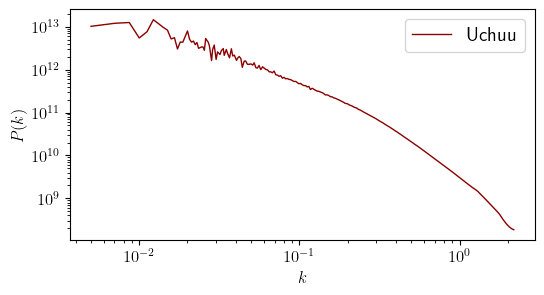

In [ ]:
from matplotlib import rcParams
import matplotlib as mpl
import numpy as np  
import torch
import matplotlib.pyplot as plt

rcParams.update({'figure.autolayout': True})
mpl.rc('axes',edgecolor='k')
plt.rcParams['savefig.dpi'] = 75
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['font.size'] = 12
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['xtick.color'] = 'k'
plt.rcParams['ytick.color'] = 'k'
plt.rcParams['text.usetex'] = True

fig, ax = plt.subplots(figsize=(6,3)) 
plt.loglog(k, PK_uchuu, label='Uchuu', c='darkred', lw=1.) 
plt.xlabel(r"$k$") 
plt.ylabel(r"$P(k)$") 
# plt.xlim(0.01, 0.1)
plt.ylim(1e12, 1e20)
plt.legend() 
plt.show()

(array([0., 0., 0., ..., 0., 0., 0.]),
 array([0.00000e+00, 1.00000e+00, 2.00000e+00, ..., 1.24997e+05,
        1.24998e+05, 1.24999e+05]),
 <BarContainer object of 124999 artists>)

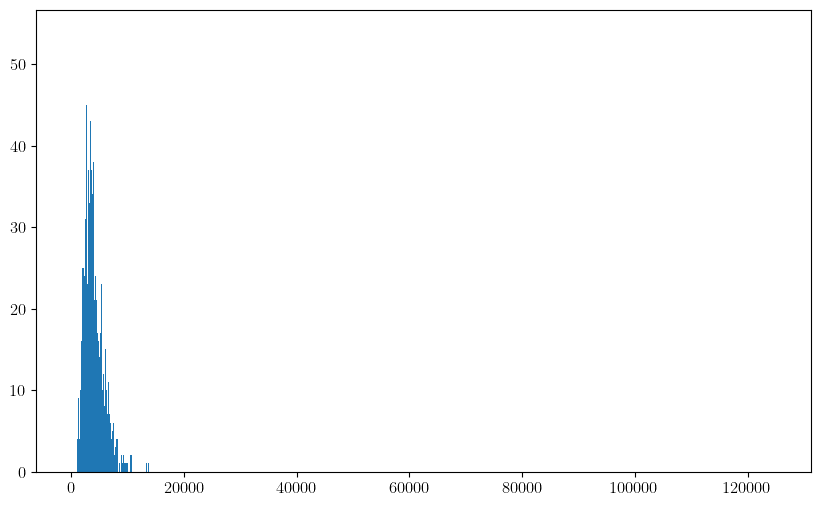

In [ ]:
index = []
multiplicity = []

for v in range(50**3):
    voxel_points = get_voxel_points(points_sorted, offsets, v)
    multiplicity.append(voxel_points.shape[0])
    index.append(v)


torch.Size([5057, 3]) torch.Size([6927, 3]) torch.Size([2729, 3]) torch.Size([2452, 3])


AttributeError: module 'matplotlib.pyplot' has no attribute 'zlim'

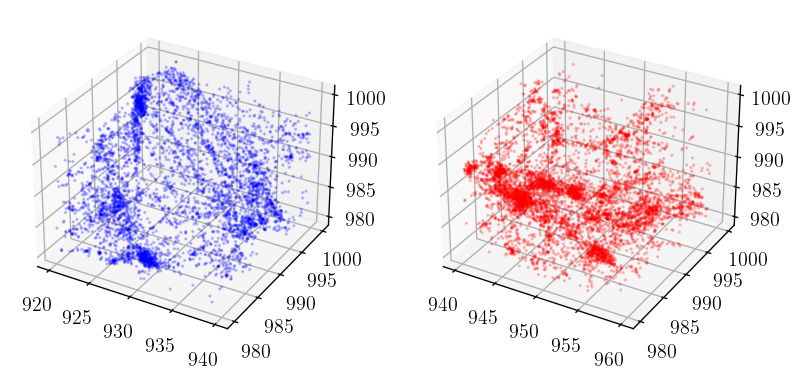

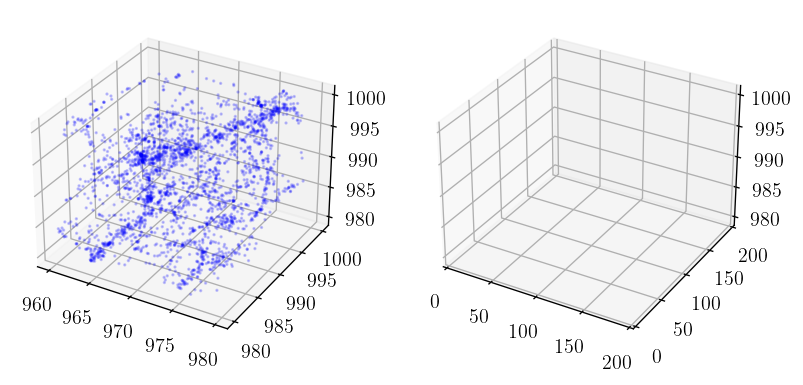

In [ ]:
from utils import plot_lss_slices, plot_lss_results

v = 125000 -4
pts_in_voxel =  get_voxel_points(points_sorted, offsets, v)
pts_in_voxel_next =  get_voxel_points(points_sorted, offsets, v+1)
pts_in_voxel_next_next =  get_voxel_points(points_sorted, offsets, v+2)
pts_in_voxel_next_next_next =  get_voxel_points(points_sorted, offsets, v+3)
plot_lss_results(pts_in_voxel, pts_in_voxel_next, marker_size=1, alpha=0.2, figsize=(8,8))
plot_lss_results(pts_in_voxel_next_next, pts_in_voxel_next_next_next, marker_size=1, alpha=0.2, figsize=(8,8))

print(pts_in_voxel.shape, pts_in_voxel_next.shape, pts_in_voxel_next_next.shape, pts_in_voxel_next_next_next.shape)
plt.xlim(0,200)
plt.ylim(0,200)

plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rcParams

rcParams.update({'figure.autolayout': True})
mpl.rc('axes',edgecolor='k')
plt.rcParams['savefig.dpi'] = 75
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['font.size'] = 12
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['xtick.color'] = 'k'
plt.rcParams['ytick.color'] = 'k'
plt.rcParams['text.usetex'] = True

fig = plt.figure(figsize=(12, 6), dpi=200)

ax = fig.add_subplot(121, projection='3d')
ax.scatter3D(pos[:,0], pos[:, 1], pos[:,2], s=0.001, c='b', alpha=0.4)
ax = fig.add_subplot(122, projection='3d')
ax.scatter3D(pos[:,0], pos[:, 1], pos[:,2], s=0.001, c='r', alpha=0.5)

KeyboardInterrupt: 

In [ ]:
lss = UchuuCentered(datafile='/home/df630/LargeScaleStructureFlows/data/Uchuu1000-Pl18_z0p00_hlist_4.h5', radius=36)
truth = lss.sample()
truth = truth.cpu().numpy()